Cython
====

Cython is an "optimizing static compiler " that combines Python with C to generate optimized code. Since Cython is a superset of Python, all valid Python programs are also valid Cython programs. However, by providing hints and static typing, we can get much faster programs. Note that while `numba` often provides similar speedups with less work,, an advantage of Cython is that it is easy to distribute optimized Cython modules since they can be built with the standard Python `setup.py` script.

We have already seen how to use Cython to wrap C and C++ functions from existing libraries. Here we will see how to use Cython to speed up Python functions. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

### Resources

- [Cython documentation](http://docs.cython.org/index.html)
- [Cython: A guide for Python programmers](http://www.amazon.com/Cython-Kurt-W-Smith/dp/1491901551)

**Utility function for timing functions**

In [2]:
import time

In [3]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start

In [4]:
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

Incremental improvements
----

Generally, we start with a pure Python function, run it through Cython with the annotate `-a` flag, and incrementally modify the code until the yellow parts are minimized.

## How to build Cython modules

Using Cython consists of these steps:

- Write a .pyx source file
- Run the Cython compiler to generate a C file
- Run a C compiler to generate a compiled library
- Run the Python interpreter and ask it to import the module

If you are developing a package and want to Cythonize some or all functions, you will need to follow the steps above. Refer to [official docs](http://docs.cython.org/index.html) - the most relevant information is [here](https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html). You should try to build a trivial package with Cython.

In the Jupyter notebook, we can use the `%%cython` cell magic to automate these steps.

In [5]:
%load_ext cython

#### Matrix multiplication example

In [6]:
def matrix_multiply(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

In [7]:
import numpy as np
u = np.random.random((10,20))
v = np.random.random((20,5))

In [8]:
res = np.zeros((u.shape[0], v.shape[1]))
matrix_multiply(u, v, res)

array([[5.28819857, 4.92009694, 6.19984975, 4.96502503, 5.4413764 ],
       [5.24114621, 5.43029087, 6.94559647, 5.07593234, 5.5442953 ],
       [4.5385604 , 4.64487102, 5.14351158, 3.18284368, 4.04290799],
       [5.68621682, 5.0272838 , 5.7722984 , 4.78287909, 5.68644012],
       [5.40108532, 5.37948773, 6.67033692, 4.60293497, 6.21043122],
       [3.69523498, 5.0616336 , 5.31608148, 3.93660024, 5.16258372],
       [4.58358545, 3.70848199, 5.03566061, 3.96088381, 4.82956606],
       [4.52492311, 5.3097423 , 5.25643487, 3.98634609, 5.76239054],
       [5.60202322, 5.60757914, 6.88260326, 5.57151343, 7.10723609],
       [3.97700115, 4.61827062, 4.65388262, 3.99595984, 4.92395776]])

In [9]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply(u, v, res)

1.07 ms ± 37.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Using Cython annnotations to identify bottlenecks

In [10]:
%%cython -a

import numpy as np

def matrix_multiply1(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

### Using Cython cdefs and directives

- `cdef` defines values and functions to be called from C
- `cpdef` defines functions that can be called from C or Python
- `cython.function` functions or decorators provide directives for how the code is compiled
- For arrays, Cython uses [typed memory views](https://cython.readthedocs.io/en/latest/src/userguide/memoryviews.html)
- `cimport` imports C libraries that can be used directly in Cython code
- To use general C functions from a header file X, use `cdef extern from "X.h` and declare the function signature
    - You can use Cython to wrap external C or C++ libraries, but this is not covered in the course. Instead, we will explore how to use `pybind11` to do that.

In [11]:
%%cython -a

import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply1(double[:,:] u, double[:, :] v, double[:, :] res):
    cdef int i, j, k
    cdef int m, n, p

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]

    with cython.nogil:
        for i in range(m):
            for j in range(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]

In [12]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply1(u, v, res)

The slowest run took 6.47 times longer than the fastest. This could mean that an intermediate result is being cached.
27 µs ± 17.7 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Parallel execution with Cython

#### Using Cython with OpenMP

Will not work unless OpenMP is installed. Note that we explicitly turn off the GIL with `cython.nogil`

In [13]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force -I /usr/local/opt/libomp/include -L /usr/local/opt/libomp/lib

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)
def matrix_multiply2(double[:,:] u, double[:, :] v, double[:, :] res):
    cdef int i, j, k
    cdef int m, n, p

    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]

    with cython.nogil, parallel():
        for i in prange(m):
            for j in prange(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]

In [14]:
res = np.zeros((u.shape[0], v.shape[1]))
%timeit -r3 -n3 matrix_multiply2(u, v, res)

10.2 ms ± 1.63 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Speeding up Mandelbrot set visualizations

In [15]:
import time

In [16]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color   

Mandelbrot created on CPU in 16.704039 s


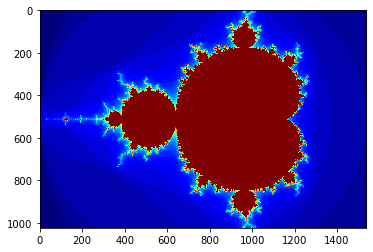

In [17]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.time()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.time() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass

Note the use of `mandel_cython` as a helper function that is only invoved in C, not in Python directly. For such functions, it is important to specify the return type.

In [18]:
%%cython -a

cimport cython

cdef extern from "complex.h":
    double cabs(double complex)

# color function for point at (x, y)
cdef unsigned char mandel_cython(double x, double y, int max_iters):
    cdef double complex c, z

    c = x + y*1j
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if cabs(z) >= 2:
            return i
    return max_iters

@cython.cdivision(True)
def create_fractal_cython(double xmin, double xmax, double ymin, double ymax, unsigned char[:, :] image, int iters):

    cdef int x, y
    cdef int height, width
    cdef double pixel_size_x, pixel_size_y
    cdef double real, imag
    cdef unsigned char color

    height = image.shape[0]
    width = image.shape[1]
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_cython(real, imag, iters)
            image[y, x]  = color  

Mandelbrot created on CPU in 0.498192 s


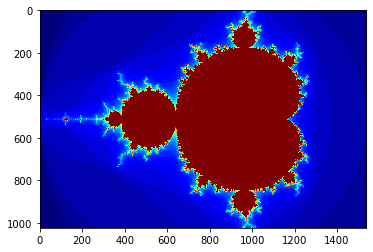

In [19]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.time()
create_fractal_cython(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.time() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass

### Using `Cython` wtih `ipyparallel`

We need to do some extra work to make sure the shared libary compiled with cython is available to the remote engines:

- Compile a `named` shared module with the `-n` flag
- Use `np.ndarray[dtype, ndim]` in place of memroy views
    - for example, double[:] becomes np.ndarray[np.float64_t, ndim=1]
- Move the shared library to the `site-packages` directory
    - Cython magic moules can be found in `~/.cache/ipython/cython`
- Import the modules remtoely in the usual ways

In [20]:
%%cython -n cylib2

import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def f(int x):
    return x*2

#### Copy the compiled module in `site-packages` so that the remote engines can import it

In [21]:
import os
import glob
import site
import shutil
import sys

if sys.platform == "darwin":
    src = glob.glob(os.path.join(os.path.expanduser('~/'), '.ipython', 'cython', 'cylib2*so'))[0]
else:
    src = glob.glob(os.path.join(os.path.expanduser('~/'), '.cache', 'ipython', 'cython', 'cylib2*so'))[0]
dst = site.getsitepackages()[0]
shutil.copy(src, dst)

'/opt/conda/lib/python3.6/site-packages/cylib2.cpython-36m-x86_64-linux-gnu.so'

In [22]:
from ipyparallel import Client

In [23]:
rc = Client()
dv = rc[:]

In [24]:
with dv.sync_imports():
    import cylib2

importing cylib2 on engine(s)


In [25]:
dv.map_sync(cylib2.f, np.random.randint(0,10,10))

[6, 12, 12, 16, 0, 8, 14, 12, 18, 4]